# Uncertainty Quantification Strategies in Neural Networks using PyTorch

In this notebook we will examine a series of methods for uncertainty quantification (UQ) using neural networks in PyTorch.

The methods that we will cover are:

* Monte Carlo Dropout
* Mixture Density Networks

We will also examine various ways to visualize the results to gain insight.

# Generate Data

We will use sklearn to generate some surrogate regression data for testing.

In [1]:
import sklearn.datasets as sdt
import matplotlib.pyplot as plt

# Create surogate data
n_samples = 1000
n_features = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 10), Shape of y: (1000, 3)


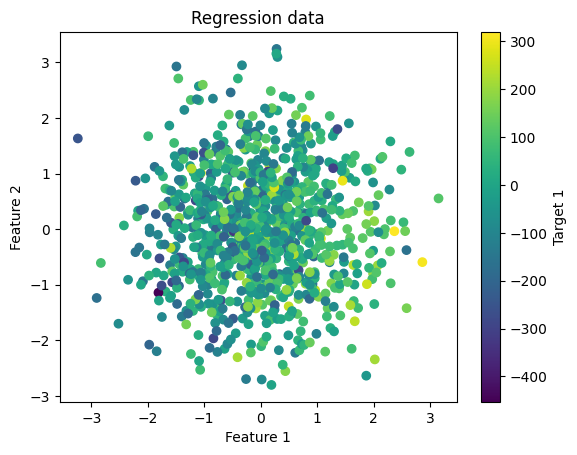

In [2]:
# Plot just the first two features
plt.scatter(x[:,0], x[:,1], c=y[:,0], cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Regression data')
plt.colorbar().set_label('Target 1')
plt.show()


# Preprocess Data

We will use sklearn preprocessing to scale the data.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale the data
x_normalizer = StandardScaler()
y_normalizer = StandardScaler()

x_norm = x_normalizer.fit_transform(x)
y_norm = y_normalizer.fit_transform(y)

# Create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

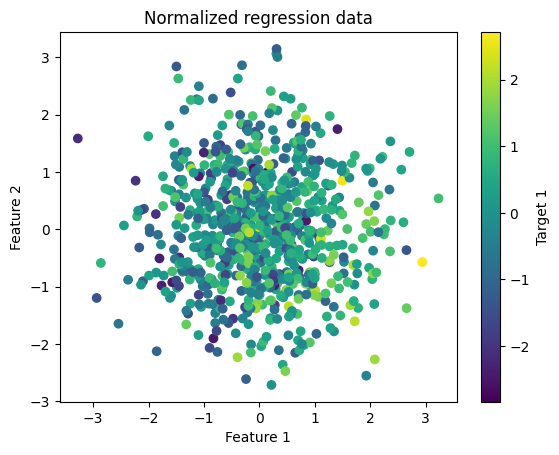

In [4]:
# Plot normalized data
plt.scatter(x_train[:,0], x_train[:,1], c=y_train[:,0], cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Normalized regression data')
plt.colorbar().set_label('Target 1')

# Building our Models

One of the strengths of neural network (NN) based methods is their inherent modularity. By developing these models in fundamental building blocks, we can see how it is relatively easy to customize them for our specific needs/goals/applications. Here we will examine a few building blocks of NNs and how they can be modified to add in uncertainty quanitification (UQ).

In [5]:
# Start with basic PyTorch
import torch
import torch.nn as nn
from torchinfo import summary

class SimpleModel(nn.Module):
    def __init__(self, width, num_inputs, num_targets, dropout=0.1, **kwargs):
        super(SimpleModel, self).__init__()

        self.width = width
        self.num_inputs = num_inputs
        self.num_targets = num_targets
        self.dropout = dropout
        
        self.layer_dict = nn.ModuleDict()

        # Dense Layers
        self.layer_dict['dense1'] = nn.Linear(self.num_inputs, self.width)
        self.layer_dict['dense2'] = nn.Linear(self.width, self.width)
        self.layer_dict['dense3'] = nn.Linear(self.width, self.num_targets)

        # Activation Layers
        self.layer_dict['relu1'] = nn.ReLU()
        self.layer_dict['relu2'] = nn.ReLU()

        # Dropout Layers
        self.layer_dict['dropout1'] = nn.Dropout(self.dropout)
        self.layer_dict['dropout2'] = nn.Dropout(self.dropout)

    def forward(self, inputs):
        x = inputs

        # First layer
        x = self.layer_dict['dense1'](x)
        x = self.layer_dict['relu1'](x)
        x = self.layer_dict['dropout1'](x)

        # Second layer
        x = self.layer_dict['dense2'](x)
        x = self.layer_dict['relu2'](x)
        x = self.layer_dict['dropout2'](x)

        # Output layer
        x = self.layer_dict['dense3'](x)

        return x
    
# Compile the model
simple_model = SimpleModel(width=32, num_inputs=n_features, num_targets=n_targets, dropout=0.1)
print(summary(simple_model, input_size=(x_train.shape[1],)))
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleModel                              [3]                       --
├─ModuleDict: 1-1                        --                        --
│    └─Linear: 2-1                       [32]                      352
│    └─ReLU: 2-2                         [32]                      --
│    └─Dropout: 2-3                      [32]                      --
│    └─Linear: 2-4                       [32]                      1,056
│    └─ReLU: 2-5                         [32]                      --
│    └─Dropout: 2-6                      [32]                      --
│    └─Linear: 2-7                       [3]                       99
Total params: 1,507
Trainable params: 1,507
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01


In [6]:
# Train the model
n_epochs = 100

train_loss = []
val_loss = []

for epoch in range(n_epochs):
    simple_model.train()
    optimizer.zero_grad()
    y_pred = simple_model(torch.Tensor(x_train))
    loss = criterion(y_pred, torch.Tensor(y_train))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    
    simple_model.eval()
    y_pred = simple_model(torch.Tensor(x_val))
    loss = criterion(y_pred, torch.Tensor(y_val))
    val_loss.append(loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train loss: {train_loss[-1]}, Val loss: {val_loss[-1]}")

Epoch 0 - Train loss: 0.9563183784484863, Val loss: 1.2929378747940063
Epoch 10 - Train loss: 0.8831052780151367, Val loss: 1.2014844417572021
Epoch 20 - Train loss: 0.7983220219612122, Val loss: 1.0895098447799683
Epoch 30 - Train loss: 0.6936692595481873, Val loss: 0.9346259832382202
Epoch 40 - Train loss: 0.5592178106307983, Val loss: 0.7284542918205261
Epoch 50 - Train loss: 0.3878704905509949, Val loss: 0.49044087529182434
Epoch 60 - Train loss: 0.23329856991767883, Val loss: 0.2738008499145508
Epoch 70 - Train loss: 0.15724439918994904, Val loss: 0.139101043343544
Epoch 80 - Train loss: 0.1287126988172531, Val loss: 0.08862870186567307
Epoch 90 - Train loss: 0.10823555290699005, Val loss: 0.07090085744857788


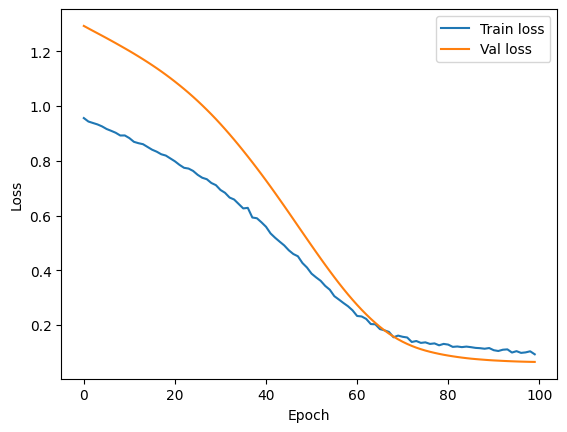

In [7]:
# Plot the loss
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [8]:
# Evaluate the model
simple_model.eval()
pred_train_norm = simple_model(torch.Tensor(x_train)).detach().numpy()
pred_test_norm = simple_model(torch.Tensor(x_test)).detach().numpy()
pred_val_norm = simple_model(torch.Tensor(x_val)).detach().numpy()

# Un-normalize the data
pred_train = y_normalizer.inverse_transform(pred_train_norm)
pred_test = y_normalizer.inverse_transform(pred_test_norm)
pred_val = y_normalizer.inverse_transform(pred_val_norm)

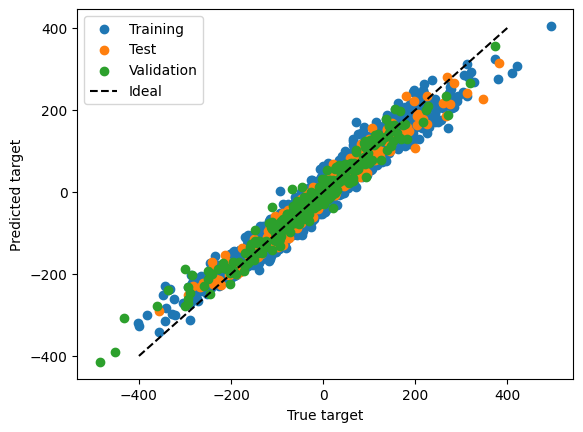

In [9]:
# Plot the results on a point-cloud plot
plt.scatter(y_train_real, pred_train, label='Training')
plt.scatter(y_test_real, pred_test, label='Test')
plt.scatter(y_val_real, pred_val, label='Validation')
plt.plot([-400, 400], [-400, 400], 'k--', label='Ideal')
plt.xlabel('True target')
plt.ylabel('Predicted target')
plt.legend()

## Make a modified version using PT-MELT Blocks

Leverage pre-defined building blocks within PT-MELT to help speed up development

In [10]:
from ptmelt.blocks import DenseBlock, DefaultOutput

class BlockModel(nn.Module):
    def __init__(self, width, num_inputs, num_targets, dropout=0.1, **kwargs):
        super(BlockModel, self).__init__()

        self.width = width
        self.num_inputs = num_inputs
        self.num_targets = num_targets
        self.dropout = dropout
        
        self.layer_dict = nn.ModuleDict()

        # Dense Block
        self.layer_dict['dense_block'] = DenseBlock(
            input_features = self.num_inputs,
            node_list = [self.width, self.width],
            activation = 'relu',
            dropout = self.dropout,
            batch_norm = False,
            initializer = 'glorot_uniform',
        )

        # Output Block
        self.layer_dict['output_block'] = DefaultOutput(
            input_features = self.width,
            output_features = self.num_targets,
            activation = None,
            initializer = 'glorot_uniform',
        )

    def forward(self, inputs):
        x = inputs

        # Dense Block
        x = self.layer_dict['dense_block'](x)

        # Output Block
        x = self.layer_dict['output_block'](x)

        return x
    
# Compile the model
block_model = BlockModel(width=32, num_inputs=n_features, num_targets=n_targets, dropout=0.1)
print(summary(block_model, input_size=(x_train.shape[1],)))
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(block_model.parameters(), lr=0.001)

Layer (type:depth-idx)                   Output Shape              Param #
BlockModel                               [3]                       --
├─ModuleDict: 1-1                        --                        --
│    └─DenseBlock: 2-1                   [32]                      --
│    │    └─ModuleDict: 3-1              --                        1,408
│    └─DefaultOutput: 2-2                [3]                       --
│    │    └─Linear: 3-2                  [3]                       99
│    │    └─Identity: 3-3                [3]                       --
Total params: 1,507
Trainable params: 1,507
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01


In [11]:
# Train the model
n_epochs = 100

train_loss = []
val_loss = []

for epoch in range(n_epochs):
    block_model.train()
    optimizer.zero_grad()
    y_pred = block_model(torch.Tensor(x_train))
    loss = criterion(y_pred, torch.Tensor(y_train))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    
    block_model.eval()
    y_pred = block_model(torch.Tensor(x_val))
    loss = criterion(y_pred, torch.Tensor(y_val))
    val_loss.append(loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train loss: {train_loss[-1]}, Val loss: {val_loss[-1]}")

Epoch 0 - Train loss: 1.1651668548583984, Val loss: 1.343226671218872
Epoch 10 - Train loss: 0.9522725343704224, Val loss: 1.2068567276000977
Epoch 20 - Train loss: 0.8110232949256897, Val loss: 1.0765461921691895
Epoch 30 - Train loss: 0.6909330487251282, Val loss: 0.9273370504379272
Epoch 40 - Train loss: 0.5690292716026306, Val loss: 0.7645202279090881
Epoch 50 - Train loss: 0.45938995480537415, Val loss: 0.5934712886810303
Epoch 60 - Train loss: 0.34980475902557373, Val loss: 0.4243650436401367
Epoch 70 - Train loss: 0.2717105746269226, Val loss: 0.2853972911834717
Epoch 80 - Train loss: 0.23184555768966675, Val loss: 0.1927024871110916
Epoch 90 - Train loss: 0.19799365103244781, Val loss: 0.14255701005458832


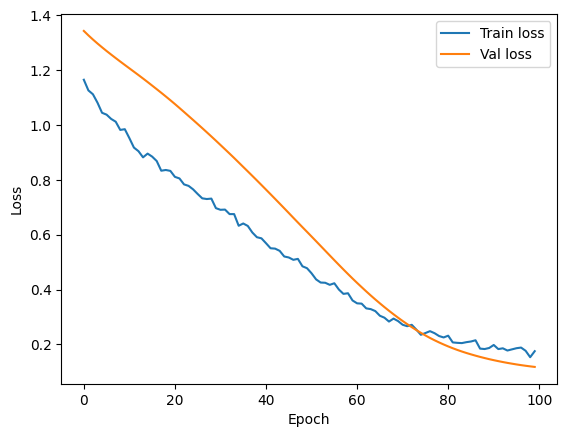

In [12]:
# Plot the loss
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [13]:
# Evaluate the model
block_model.eval()
pred_train_norm = block_model(torch.Tensor(x_train)).detach().numpy()
pred_test_norm = block_model(torch.Tensor(x_test)).detach().numpy()
pred_val_norm = block_model(torch.Tensor(x_val)).detach().numpy()

# Un-normalize the data
pred_train = y_normalizer.inverse_transform(pred_train_norm)
pred_test = y_normalizer.inverse_transform(pred_test_norm)
pred_val = y_normalizer.inverse_transform(pred_val_norm)

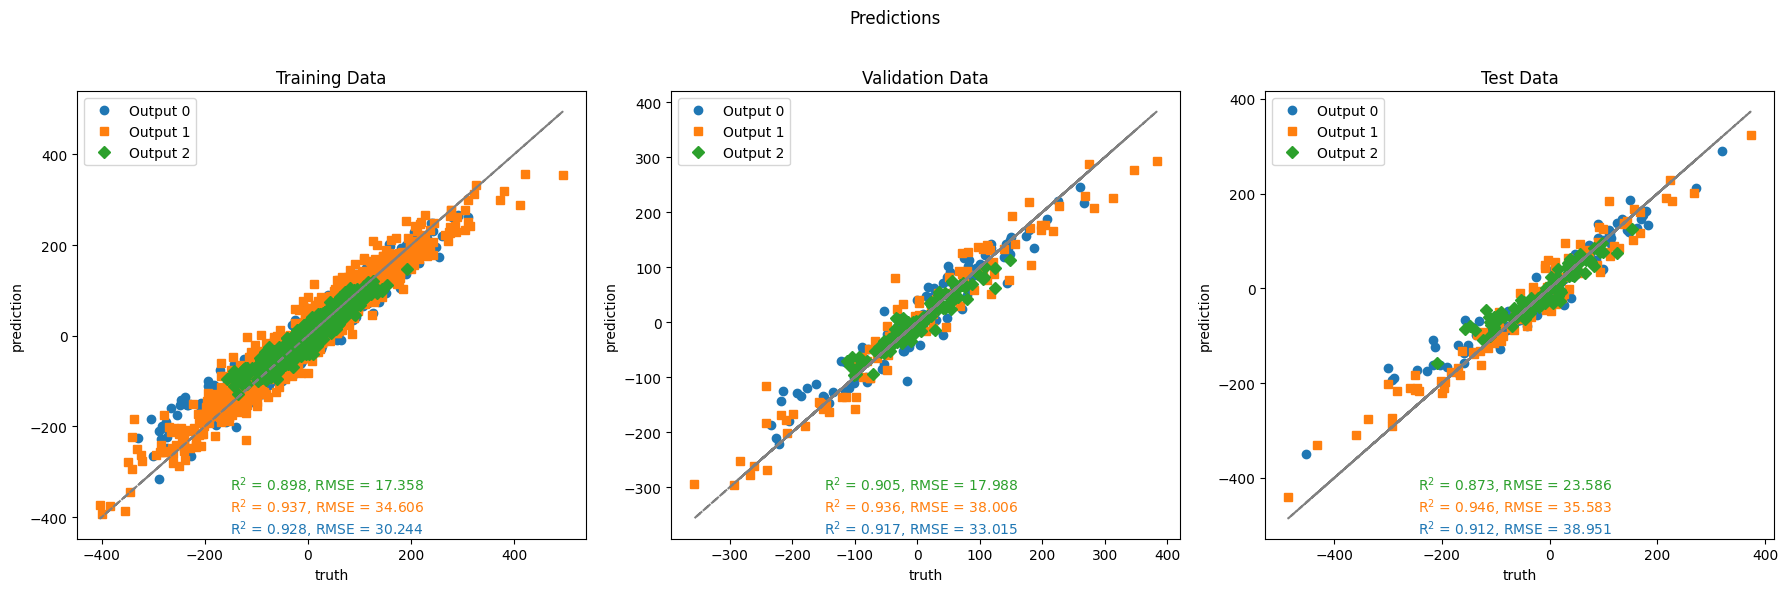

In [14]:
from ptmelt.utils.visualization import plot_predictions

plot_predictions(pred_train, y_train_real, pred_test, y_test_real, pred_val, y_val_real)

# Monte Carlo Dropout

Dropout layers are enabled during training and disabled during evaluation. If you manually enable dropout layers during evaluation you can sample the network multiple times and form an ensemble of predictions that will each represent a thinned model. From that ensemble we can evaluate statistics.

In [15]:
import numpy as np

# Evaluate the model with training enabled and form an ensemble
n_iter = 100

pred_train_list = []
pred_test_list = []
pred_val_list = []

for i in range(n_iter):
    block_model.train()
    pred_train_norm = block_model(torch.from_numpy(x_train).float())
    pred_test_norm = block_model(torch.from_numpy(x_test).float())
    pred_val_norm = block_model(torch.from_numpy(x_val).float())

    pred_train = y_normalizer.inverse_transform(pred_train_norm.detach().numpy())
    pred_test = y_normalizer.inverse_transform(pred_test_norm.detach().numpy())
    pred_val = y_normalizer.inverse_transform(pred_val_norm.detach().numpy())


    pred_train_list.append(pred_train)
    pred_test_list.append(pred_test)
    pred_val_list.append(pred_val)

# Average the predictions
pred_train_mean = np.mean(np.array(pred_train_list), axis=0)
pred_test_mean = np.mean(np.array(pred_test_list), axis=0)
pred_val_mean = np.mean(np.array(pred_val_list), axis=0)

# Calculate the standard deviation
pred_train_std = np.std(np.array(pred_train_list), axis=0)
pred_test_std = np.std(np.array(pred_test_list), axis=0)
pred_val_std = np.std(np.array(pred_val_list), axis=0)


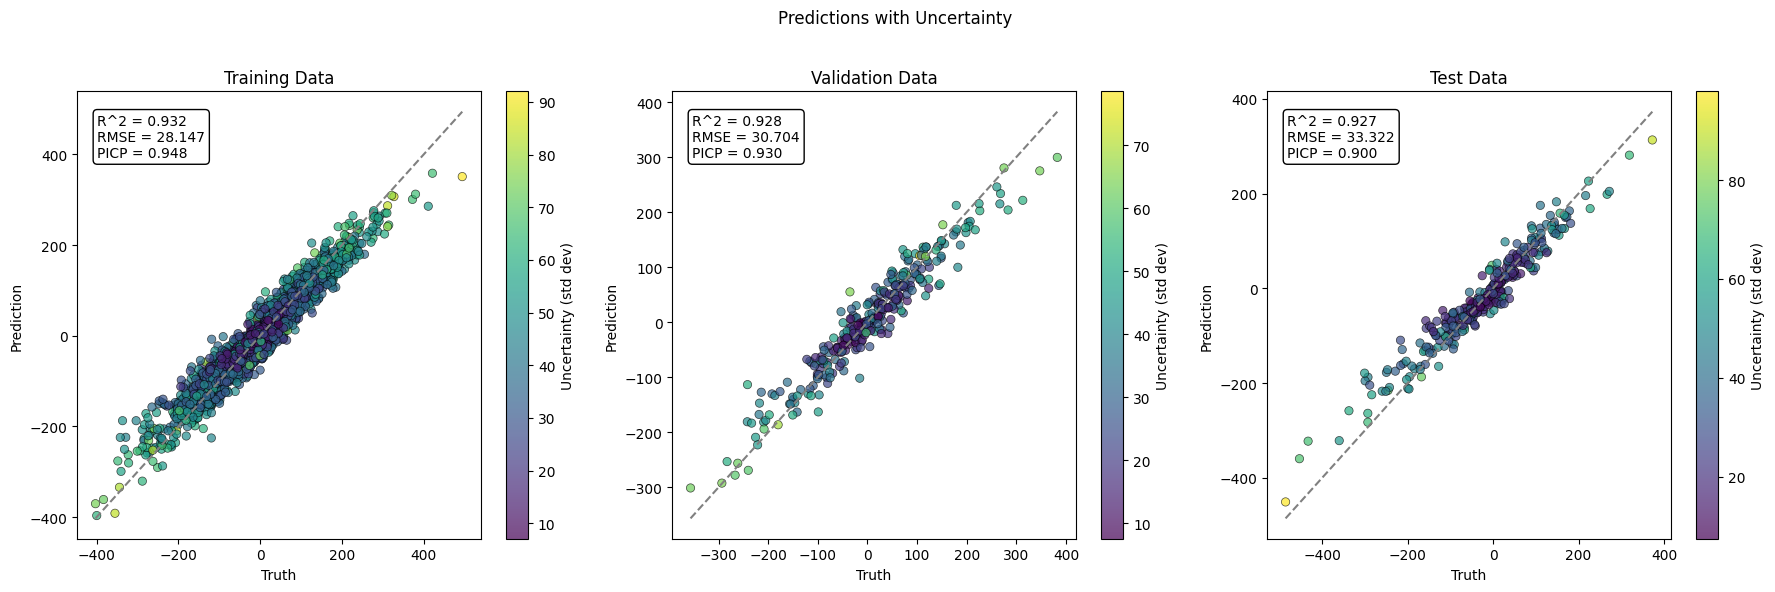

In [16]:
from ptmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot MC Dropout results
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_test_mean, pred_test_std, y_test_real,
    pred_val_mean, pred_val_std, y_val_real,
    metrics_to_display=["R^2", "RMSE", "PICP"],
)

# Heteroscedastic Neural Networks and Mixture Density Networks

Now, let's look at how to form UQ estimates by modifying the output of a block NN without having to create an ensemble. Here, we will directly predict both the value and the uncertainty of that value through a negative log-likelihood loss function.

In [17]:
from ptmelt.models import ArtificialNeuralNetwork
from torch import optim

# Create the model
hnn_model = ArtificialNeuralNetwork(
    num_features=n_features,
    num_outputs=n_targets,
    node_list = [32, 32],
    act_fun="relu",
    dropout=0.1,
    batch_norm=False,
    output_activation=None,
    num_mixtures=1,
)

# Build the model and print the summary
hnn_model.build()
print(summary(hnn_model, input_size=(1, n_features)))

# Define the loss function and optimizer for training
criterion = hnn_model.get_loss_fn(loss="mse", reduction="mean")
optimizer = optim.Adam(hnn_model.parameters(), lr=1e-3)

Layer (type:depth-idx)                   Output Shape              Param #
ArtificialNeuralNetwork                  [1, 7]                    --
├─ModuleDict: 1-1                        --                        --
│    └─DenseBlock: 2-1                   [1, 32]                   --
│    │    └─ModuleDict: 3-1              --                        1,408
│    └─MixtureDensityOutput: 2-2         [1, 7]                    --
│    │    └─Linear: 3-2                  [1, 1]                    33
│    │    └─Softmax: 3-3                 [1, 1]                    --
│    │    └─Linear: 3-4                  [1, 3]                    99
│    │    └─Identity: 3-5                [1, 3]                    --
│    │    └─Linear: 3-6                  [1, 3]                    99
│    │    └─Identity: 3-7                [1, 3]                    --
Total params: 1,639
Trainable params: 1,639
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass 

/Users/nwimer/miniconda3/envs/nrel-ai/lib/python3.11/site-packages/ptmelt/models.py:183: UserWarning: Mixture Density Networks require the use of the MixtureDensityLoss class. The loss function will be set to automatically.
  warnings.warn(


In [18]:
from torch.utils.data import DataLoader, TensorDataset

# Create the data holder for training/validation (the test set should be held separate from any model training)
dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
dataset_val = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).float())

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

In [19]:
# Fit the model using the built-in training loop
hnn_model.fit(
    train_dl = dataloader,
    val_dl = dataloader_val,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=n_epochs,
)

history = hnn_model.history

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:01, 59.44it/s]

Epoch 10, Loss: 2.4173, Val Loss: 2.2983
Epoch 20, Loss: 2.1372, Val Loss: 1.9420


 40%|████      | 40/100 [00:00<00:00, 61.91it/s]

Epoch 30, Loss: 2.0183, Val Loss: 1.8192
Epoch 40, Loss: 1.8558, Val Loss: 1.7362


 61%|██████    | 61/100 [00:01<00:00, 61.78it/s]

Epoch 50, Loss: 1.7915, Val Loss: 1.6127
Epoch 60, Loss: 1.7012, Val Loss: 1.6187


 82%|████████▏ | 82/100 [00:01<00:00, 62.66it/s]

Epoch 70, Loss: 1.6856, Val Loss: 1.4733
Epoch 80, Loss: 1.6354, Val Loss: 1.5021


100%|██████████| 100/100 [00:01<00:00, 61.28it/s]

Epoch 90, Loss: 1.5876, Val Loss: 1.5467
Epoch 100, Loss: 1.6033, Val Loss: 1.3393


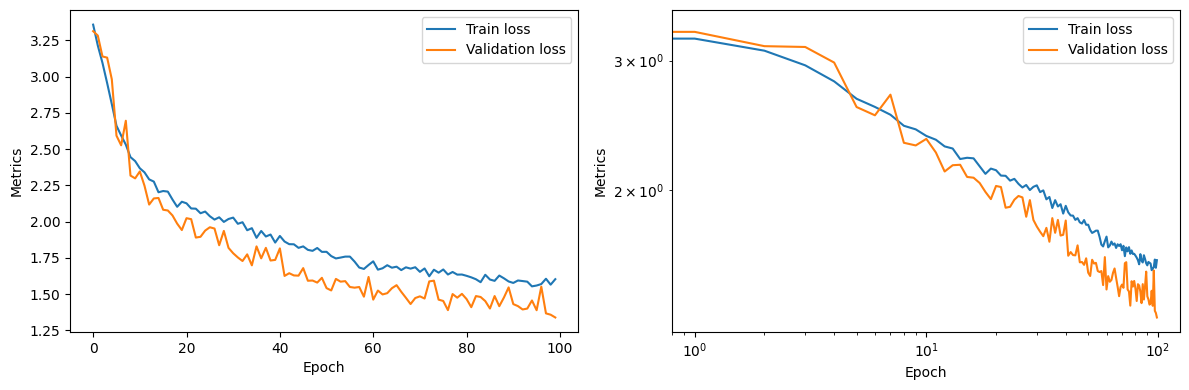

In [20]:
from ptmelt.utils.visualization import plot_history

# Plot the training history
plot_history(history, metrics=["loss"], plot_log=True)

In [21]:
from ptmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train, pred_train_std = make_predictions(hnn_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val, pred_val_std = make_predictions(hnn_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test, pred_test_std = make_predictions(hnn_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

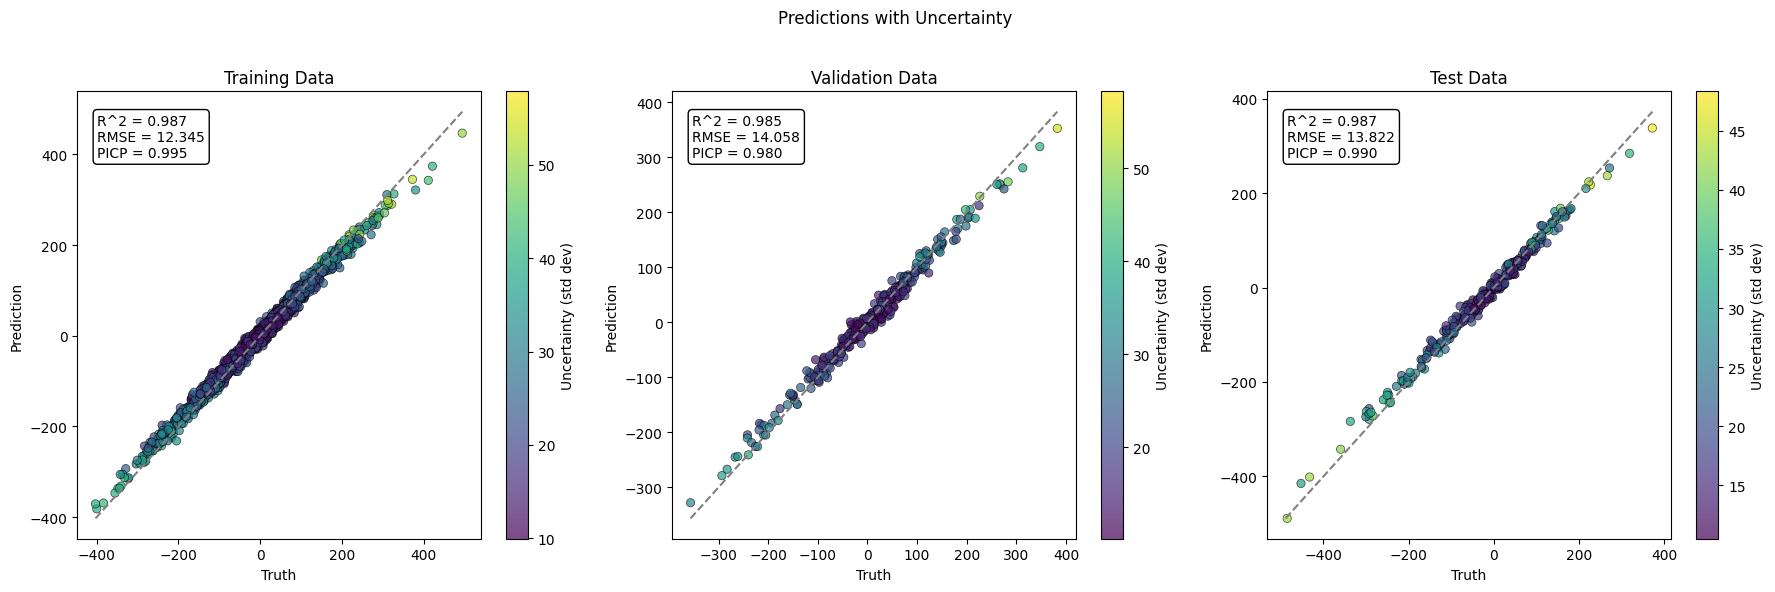

In [22]:
from ptmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the results
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_test, pred_test_std, y_test_real,
    pred_val, pred_val_std, y_val_real,
    metrics_to_display=["R^2", "RMSE", "PICP"],
)

## Mixture Density Network

In [23]:
from ptmelt.models import ArtificialNeuralNetwork
from torch import optim

# Create the model
mdn_model = ArtificialNeuralNetwork(
    num_features=n_features,
    num_outputs=n_targets,
    node_list = [32, 32],
    act_fun="relu",
    dropout=0.1,
    batch_norm=False,
    output_activation=None,
    num_mixtures=5,
)

# Build the model and print the summary
mdn_model.build()
print(summary(mdn_model, input_size=(1, n_features)))

# Define the loss function and optimizer for training
criterion = mdn_model.get_loss_fn(loss="mse", reduction="mean")
optimizer = optim.Adam(mdn_model.parameters(), lr=1e-3)

Layer (type:depth-idx)                   Output Shape              Param #
ArtificialNeuralNetwork                  [1, 35]                   --
├─ModuleDict: 1-1                        --                        --
│    └─DenseBlock: 2-1                   [1, 32]                   --
│    │    └─ModuleDict: 3-1              --                        1,408
│    └─MixtureDensityOutput: 2-2         [1, 35]                   --
│    │    └─Linear: 3-2                  [1, 5]                    165
│    │    └─Softmax: 3-3                 [1, 5]                    --
│    │    └─Linear: 3-4                  [1, 15]                   495
│    │    └─Identity: 3-5                [1, 15]                   --
│    │    └─Linear: 3-6                  [1, 15]                   495
│    │    └─Identity: 3-7                [1, 15]                   --
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pa

/Users/nwimer/miniconda3/envs/nrel-ai/lib/python3.11/site-packages/ptmelt/models.py:183: UserWarning: Mixture Density Networks require the use of the MixtureDensityLoss class. The loss function will be set to automatically.
  warnings.warn(


In [24]:
from torch.utils.data import DataLoader, TensorDataset

# Create the data holder for training/validation (the test set should be held separate from any model training)
dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
dataset_val = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).float())

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

In [25]:
# Fit the model using the built-in training loop
mdn_model.fit(
    train_dl = dataloader,
    val_dl = dataloader_val,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=n_epochs,
)

history = mdn_model.history

 18%|█▊        | 18/100 [00:00<00:01, 57.01it/s]

Epoch 10, Loss: 2.2395, Val Loss: 2.0201
Epoch 20, Loss: 2.0035, Val Loss: 1.7936


 38%|███▊      | 38/100 [00:00<00:01, 59.43it/s]

Epoch 30, Loss: 1.9258, Val Loss: 1.7532
Epoch 40, Loss: 1.8203, Val Loss: 1.5926


 58%|█████▊    | 58/100 [00:00<00:00, 59.97it/s]

Epoch 50, Loss: 1.7788, Val Loss: 1.5581
Epoch 60, Loss: 1.6653, Val Loss: 1.4995


 78%|███████▊  | 78/100 [00:01<00:00, 59.65it/s]

Epoch 70, Loss: 1.6241, Val Loss: 1.4946
Epoch 80, Loss: 1.6303, Val Loss: 1.5584


100%|██████████| 100/100 [00:01<00:00, 58.86it/s]

Epoch 90, Loss: 1.5498, Val Loss: 1.4269
Epoch 100, Loss: 1.5656, Val Loss: 1.4607


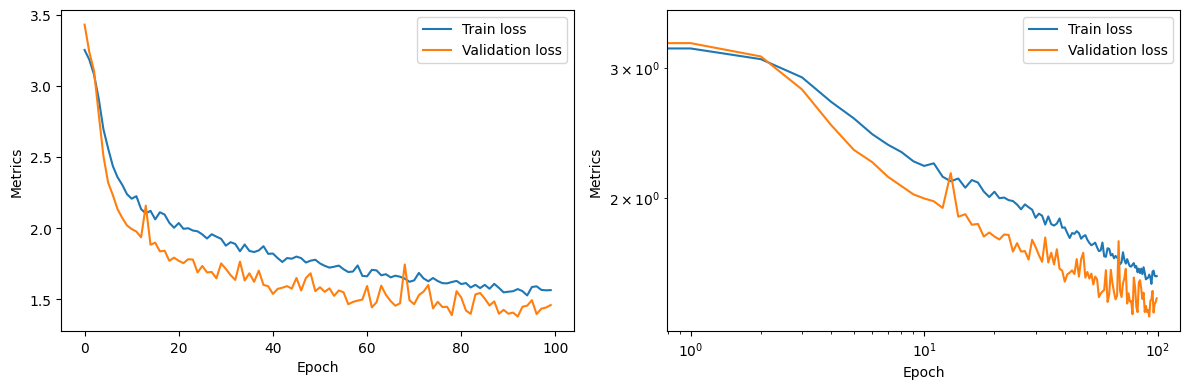

In [26]:
from ptmelt.utils.visualization import plot_history

# Plot the training history
plot_history(history, metrics=["loss"], plot_log=True)

In [27]:
from ptmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train, pred_train_std = make_predictions(mdn_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val, pred_val_std = make_predictions(mdn_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test, pred_test_std = make_predictions(mdn_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

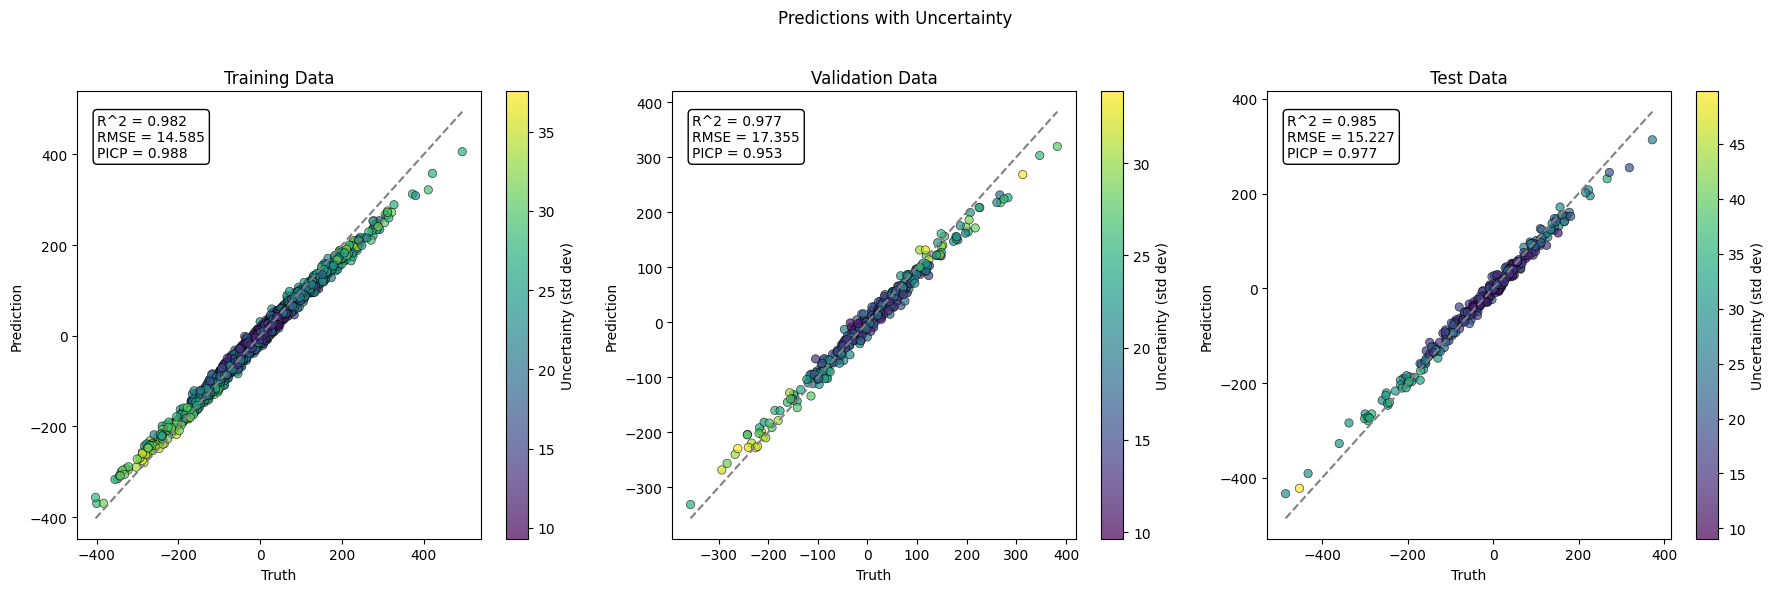

In [28]:
from ptmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the results
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_test, pred_test_std, y_test_real,
    pred_val, pred_val_std, y_val_real,
    metrics_to_display=["R^2", "RMSE", "PICP"],
)